In [33]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as spio
import numpy as np
# from scipy.misc import imresize
from scipy.spatial import distance
from IPython.display import display
from skimage.transform import rescale, resize
from statsmodels.robust.scale import mad
# OG_DATA_PATH = './TaskPerformance/'
PLOTS_PATH = './Sabine_paper/'
POS_PATH = './position/'
EYE_DATA_PATH = './ET_data/'
CSV_PATH = './csv_files'
MOUSE_DATA_PATH = './MouseData'
os.makedirs(os.path.dirname(PLOTS_PATH), exist_ok=True)
sns.set(context = "paper", style="white", palette="Set1", font_scale=2.5, rc={'figure.figsize':(12,9)})


# DWELLING TIME ON HOUSES

In [2]:
rep_measurements = pd.read_csv('{}/combinedSessions_newPartNumbers.csv'.format(EYE_DATA_PATH))
house_df = pd.read_csv('{}/seahaven_house_info.csv'.format(CSV_PATH))
display(house_df.info())
display(rep_measurements.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 4 columns):
HouseNr    193 non-null int64
Angle      193 non-null float64
x          193 non-null float64
y          193 non-null float64
dtypes: float64(3), int64(1)
memory usage: 6.2 KB


None

,newPartNumber,Session1,Session2,Session3,Identifier
0,21,1909,8551,9437,a
1,22,3668,1540,1155,b
2,23,8466,8041,8547,c
3,24,3430,3693,8261,d
4,25,6348,5696,3023,e


In [27]:
def mad_based_outlier(points, thresh=3.5):
    """ Median Absolute deviation based outlier detection.
    Ideally this method should be used to clean fixation durations."""
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score < thresh

./ET_data/gazes_25.csv not found, Moving on.
./ET_data/gazes_32.csv not found, Moving on.


,Time,Samples,Distances,Subject
count,120332.000000,120332.000000,120332.000000,120332.000000
mean,805.068477,24.155378,43.289356,33.154763
std,975.197241,29.253741,47.625082,7.756200
min,0.000000,8.000000,0.000000,21.000000
25%,333.333333,10.000000,16.569554,27.000000
50%,500.000000,15.000000,29.311508,33.000000
75%,866.666667,26.000000,50.240762,38.000000
max,51666.666667,1550.000000,523.913343,46.000000


C:\Users\akeshava\.conda\envs\conda_env\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


House          004_0
Time         18866.7
Samples          566
Distances    69.3057
Subject           45
Name: 114481, dtype: object

<bound method NDFrame.describe of           House         Time  Samples  Distances  Subject
0         103_3   833.333333       25  13.115008       21
2         054_0   266.666667        8  32.930764       21
12        008_0  1166.666667       35  24.144433       21
13        156_6   533.333333       16  76.231603       21
14        013_0   266.666667        8  23.136485       21
...         ...          ...      ...        ...      ...
120326  021_0_3  1566.666667       47  81.689590       46
120327  021_0_3   466.666667       14  81.150785       46
120328  021_0_3  1200.000000       36  81.288778       46
120329  021_0_4   500.000000       15  85.663370       46
120331  021_0_3   266.666667        8  81.735760       46

[71603 rows x 5 columns]>

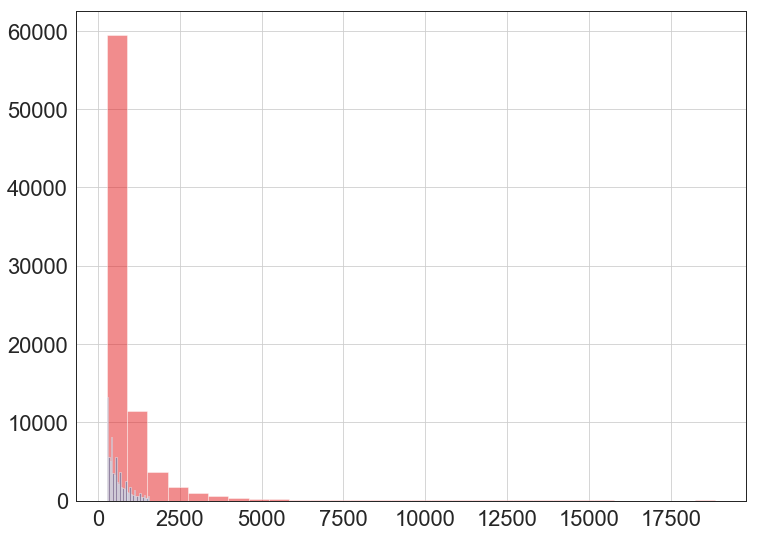

In [35]:
eye_df = pd.DataFrame()
for subID in rep_measurements.newPartNumber.values:
    try:
        tmpdf = pd.read_csv('{}gazes_{}.csv'.format(EYE_DATA_PATH,subID))
        tmpdf['Subject'] = subID
        eye_df = pd.concat([eye_df, tmpdf], ignore_index=True)
    except OSError:
        print('{}gazes_{}.csv not found, Moving on.'.format(EYE_DATA_PATH,subID))   

display(eye_df.describe())

eye_df = eye_df.query('House != "NH" and House != "sky" and House != "noData"')
# display(eye_df.describe())
display(eye_df.loc[eye_df.Time.argmax()])
ax = eye_df.Time.hist(bins=30, label='before filtering', alpha=0.5,)
# dwelling time has large outliers, needs to be cleaned
eye_df = eye_df.loc[mad_based_outlier(eye_df.Time)]
display(eye_df.describe)
eye_df.Time.hist(bins=30, label='after filtering',alpha=0.5, ax=ax)

'Mean dwelling Time over houses and subjects: 574.7854218108351ms (SD=51.23039296332182)'

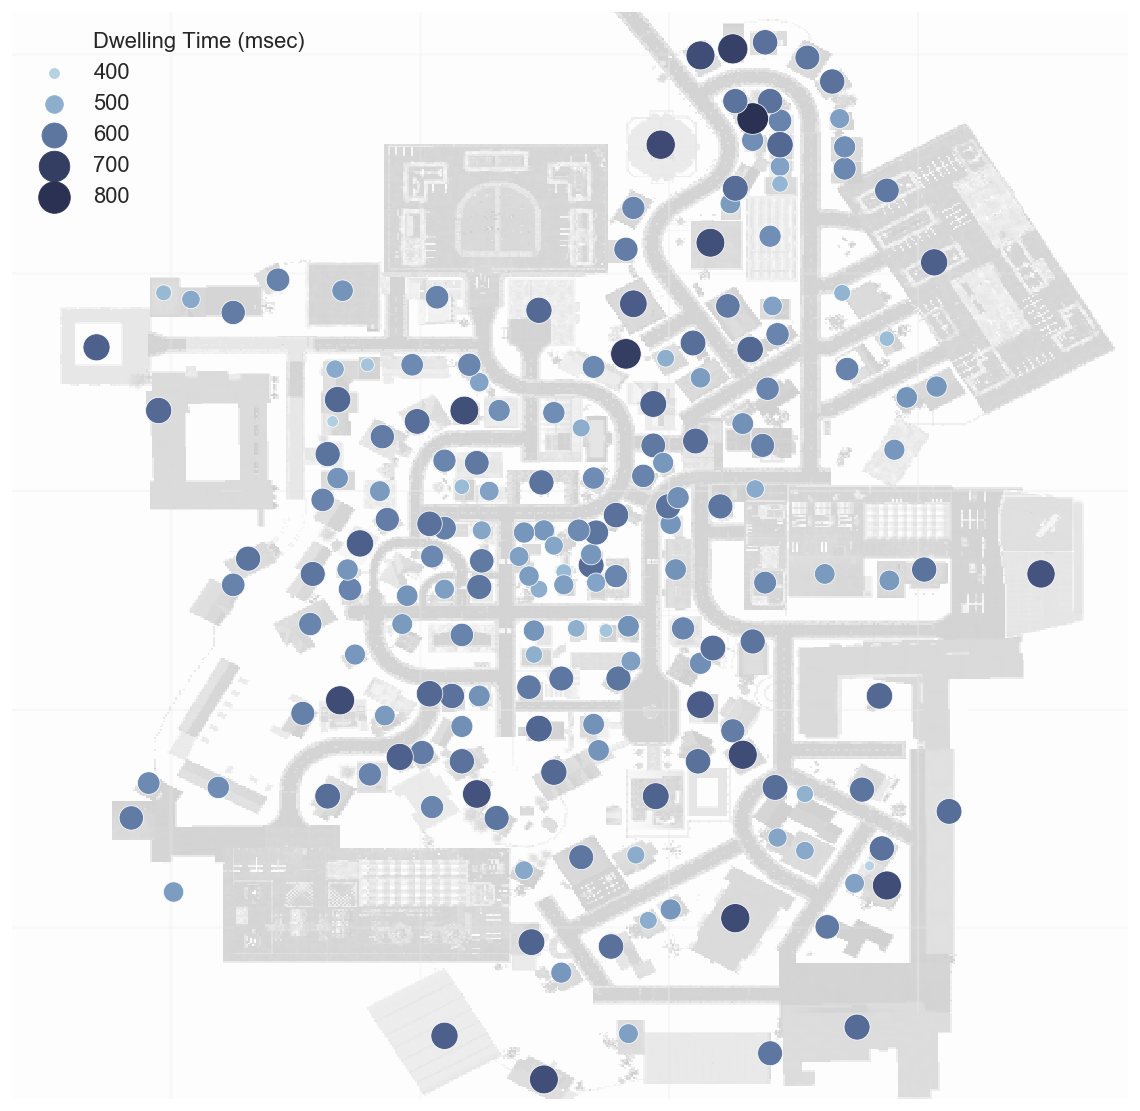

In [36]:
eye_df.House = eye_df.House.str.strip()
# sub_fixDur = eye_df.groupby(['Subject','House']).agg({'Time':'mean'})
eye_df[['HouseNr', 'Angle', 'Other']] = eye_df.House.str.split('_', expand=True)
eye_df.HouseNr = eye_df.HouseNr.astype(int)
eye_df = eye_df.merge(house_df, on = 'HouseNr')
sub_fixDur = eye_df.groupby(['HouseNr','x', 'y' ]).agg({'Time':'mean'}).reset_index()
display(f'Mean dwelling Time over houses and subjects: {sub_fixDur.Time.mean()}ms (SD={sub_fixDur.Time.std()})')
# rescaling x,y coordinates to fit 2D Map
sub_fixDur.x = sub_fixDur.x.astype(int) - 180
sub_fixDur.y = sub_fixDur.y.astype(int) - 535
sub_fixDur.Time = sub_fixDur.Time.astype(int)
# display(sub_fixDur)   


map_img = plt.imread('./map_grey.png')
# map_img = map_img.resize((450,500))
sns.set(context = "paper", style="white", palette="Set1", font_scale=2.5, rc={'figure.figsize':(12,9)})
# display(map_img.shape)
_, ax = plt.subplots(figsize=(20,20))

# cmap = sns.color_palette("Blues", as_cmap=True)
sub_fixDur.rename(columns={'Time':'Dwelling Time (msec)'}, inplace=True)

cmap = sns.cubehelix_palette(dark=0.2, light=0.8,rot=-.15, as_cmap=True)
ax.imshow(map_img, interpolation='nearest',aspect = 'auto',extent =[1,450,500,1], origin='upper')
ax = sns.scatterplot(x='y', y='x', hue='Dwelling Time (msec)', size='Dwelling Time (msec)',
                     sizes=(100, 1000), 
                     palette=cmap, 
                     data=sub_fixDur)


# plt.gca().invert_yaxis()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_xticklabels([''])
plt.gca().set_yticklabels([''])
plt.gca().set_xlabel('')
plt.gca().set_ylabel('')
plt.legend(frameon =False)
plt.savefig(PLOTS_PATH+'/dwellingTime.png', quality=90, transparent=True)

## Accuracy as a function of familiarity of houses

In [37]:
mousedf = pd.read_csv(f'{MOUSE_DATA_PATH}/ClickStatsAll3M.csv')
mousedf = pd.melt(mousedf, id_vars='House', value_vars = [ col for col in mousedf.columns if col !='House'], 
                  var_name='subject', value_name='clickNum' )
mousedf = mousedf.merge(house_df, left_on = 'House', right_on='HouseNr')
# display(mousedf)
clickdf = mousedf.groupby(['HouseNr','x', 'y' ]).agg({'clickNum':'mean'}).reset_index()
display(f'Mean Number of Clicks over houses and subjects: {clickdf.clickNum.mean()} (SD= {clickdf.clickNum.std()})')

clickdf.x = clickdf.x.astype(int) - 180
clickdf.y = clickdf.y.astype(int) - 535
clickdf.clickNum = clickdf.clickNum.astype(int)

'Mean Number of Clicks over houses and subjects: 3.207646412309624 (SD= 1.1874492349973813)'

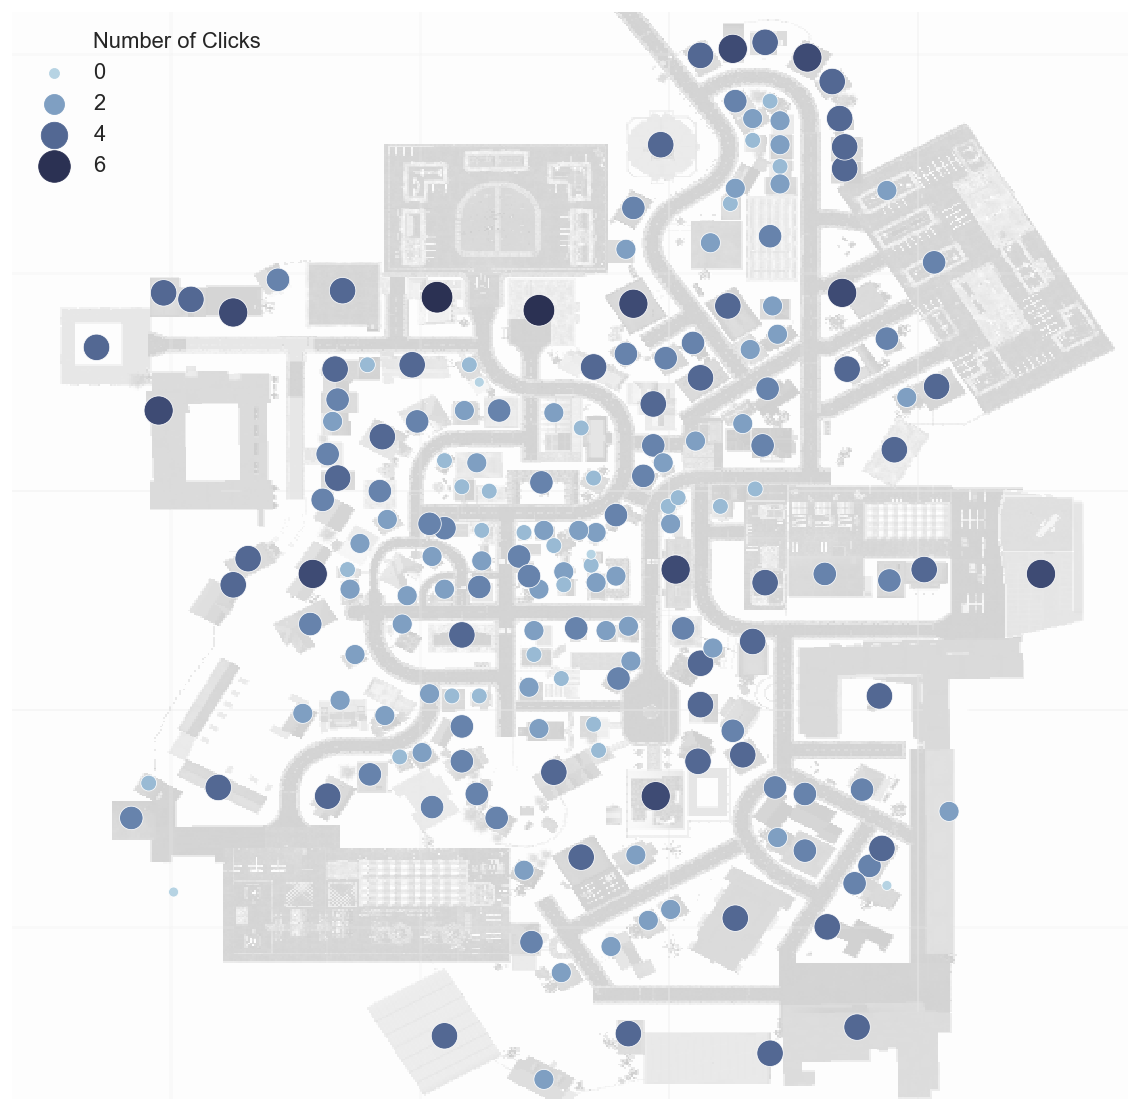

In [38]:
map_img = plt.imread('./map_grey.png')
# map_img = map_img.resize((450,500))
sns.set(context = "paper", style="white", palette="Set1", font_scale=2.5, rc={'figure.figsize':(12,9)})
# display(map_img.shape)
_, ax = plt.subplots(figsize=(20,20))

# cmap = sns.color_palette("Blues", as_cmap=True)
clickdf.rename(columns={'clickNum':'Number of Clicks'}, inplace=True)

cmap = sns.cubehelix_palette(dark=0.2, light=0.8,rot=-.15, as_cmap=True)
ax.imshow(map_img, interpolation='nearest',aspect = 'auto',extent =[1,450,500,1], origin='upper')
ax = sns.scatterplot(x='y', y='x', hue='Number of Clicks', size='Number of Clicks',
                     sizes=(100, 1000), 
                     palette=cmap, 
                     data=clickdf)


# plt.gca().invert_yaxis()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_xticklabels([''])
plt.gca().set_yticklabels([''])
plt.gca().set_xlabel('')
plt.gca().set_ylabel('')
plt.legend(frameon =False, loc='upper left')
plt.savefig(PLOTS_PATH+'/mouseclicks.png', quality=90, transparent=True)